#### SVM Classification of brain regions based on the distribution of cell clusters
This notebook is used to generate Figure 3e/f. It first plots the number of neurons that were categorized into the determined clusters for each brain area. A support vector machine (SVM) classifier with a polynomial kernel was also implemented in this notebook to classify brain areas based on the distribution of cell clusters. The performance of this classifier is evaluated through a normalized confusion matrix.

In [1]:
import os, glob
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

c:\Users\jp\anaconda3\envs\ana_312\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
bin_size = 500
opt_norm = True
opt_fr_thres = 5
monkey = 'VM20_VM23'
rnd_seed = 42
n_clusters = 3
nLimit = 70

# Replace path with your data path:
pn_root = r"\\NJJK-NAS\visual\66_paper\MANUSCRIPT\20250610-v6-submit\figShare_upload\DATA"

homedir = glob.glob(os.path.join(pn_root, fr'04_result_{bin_size}ms\b3_task_raster\{monkey}'), recursive=True)[0]
brain_region_list = sorted(next(os.walk(homedir))[1])

In [3]:
# Find brain regions less than nLimit
rm_list = []
for reg in brain_region_list:
    channel_list = sorted(glob.glob(os.path.join(homedir,reg,'*.csv')))
    if len(channel_list) < nLimit:
        rm_list.append(reg)

In [4]:
# remove regions
brain_region_list = list(filter(lambda a: a not in rm_list, brain_region_list))

savedir = os.path.join(homedir.replace(f'04_result_{bin_size}ms', '05_plots'),f'NumOver{nLimit}')
os.makedirs(savedir, exist_ok=True)

cluster_labels = pd.read_csv(os.path.join(homedir,f'hierarchical_ClusterLabel_{monkey}_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'), usecols=["Region", "Cluster"])

In [5]:
df_count = pd.crosstab(cluster_labels['Region'],cluster_labels['Cluster'],normalize='index')
df_count.to_csv(os.path.join(homedir,f'hierarchical_region_cluster_count_{monkey}_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'))
df_count

Cluster,1,2,3
Region,,,
01_V1,0.141593,0.420354,0.438053
02_V2,0.210526,0.210526,0.578947
03_V4,0.028986,0.659420,0.311594
05_PF,0.418367,0.234694,0.346939
06_PFG,0.281250,0.156250,0.562500
07_PE,0.139752,0.425466,0.434783
09_S2,0.367442,0.320930,0.311628
11_M1,0.207188,0.374207,0.418605
12_PMDc,0.142857,0.589286,0.267857


Bar plot illustrating the number of neurons that were categorized into the three clusters in (c) for each brain area, with only brain areas having a total neuron count greater than nLimit(70) included.

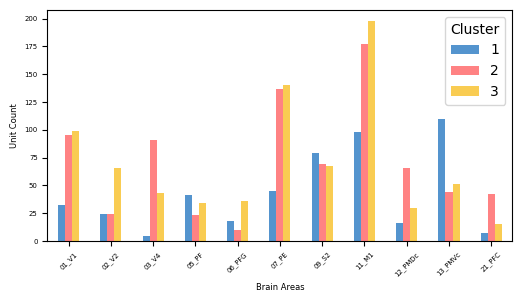

<Figure size 640x480 with 0 Axes>

In [6]:
# define color
if n_clusters == 2:
    hex_colors = ['#5494CE', '#F9CC52']
elif n_clusters == 3:
    hex_colors = ['#5494CE', '#FF8283', '#F9CC52']
elif n_clusters == 4:
    hex_colors = ['#5494CE', '#FF8283', '#0D898A', '#F9CC52']
elif n_clusters == 6:
    hex_colors = ['#f57c6e', '#f2b56f', '#84c3b7', '#71b7ed', '#b8aeeb', '#f2a7da']
# Create a ListedColormap from the hex colors
cmap = mcolors.ListedColormap(hex_colors)

plot_labels = cluster_labels.loc[cluster_labels['Cluster'] >= 0]
pd.crosstab(plot_labels['Region'],plot_labels['Cluster']).plot.bar(figsize=(6,3), colormap=cmap)
plt.xticks(rotation=45)
plt.ylabel('Unit Count', fontsize=6)
plt.xlabel('Brain Areas', fontsize=6)
plt.tick_params(axis='both', labelsize=5)
plt.savefig(os.path.join(savedir, f'hierarchical_barPlot_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}.pdf'), transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(savedir, f'hierarchical_barPlot_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}.png'))
plt.show()
plt.clf()

SVM Classification Analysis

In [7]:
# Create empty array
X = np.empty((0, n_clusters))
y = np.empty((0, 1))
# Repeat the process for 1000 times
for rnd in range(1000):
    # Randomly select 1000 neurons from the entire population
    df_tmp = cluster_labels.sample(n=1000)
    # Count the number of neurons belonging to the three clusters for each region
    ncounts = pd.crosstab(df_tmp['Region'],df_tmp['Cluster'])
    # Convert counts to percentages
    nprct = pd.crosstab(df_tmp['Region'],df_tmp['Cluster']).apply(lambda r: r/r.sum(), axis=1)
    nprct['Total'] = ncounts.sum(axis=1, numeric_only=True)
    # Keep regions where more than 20 neurons are selected
    nprct = nprct[nprct.Total >=20]
    data_x = nprct.loc[:, nprct.columns != 'Total'].to_numpy()
    data_y = np.array(nprct.index).reshape(-1,1)
    # combine data
    X = np.vstack((X, data_x))
    y = np.vstack((y, data_y))

In [8]:
# Divide the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [9]:
# Compare RBF Kernel and Polynomial Kernel 
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

c:\Users\jp\anaconda3\envs\ana_312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jp\anaconda3\envs\ana_312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy (Polynomial Kernel):  77.55
F1 (Polynomial Kernel):  75.89
Accuracy (RBF Kernel):  68.77
F1 (RBF Kernel):  65.38


Normalized confusion matrix evaluating the performance of the SVM classifier with polynomial kernel

In [10]:
# Choose the one with the higher classification accuracy: polynomial kernel 
# Get the confusion matrix
cf_matrix = confusion_matrix(y_test, poly_pred, labels=np.unique(y))
labels = np.unique(y)
# Print confusion matrix with labels
print("Confusion Matrix:")
print(cf_matrix)

# Print labels for interpretation
print("\nLabels:")
print(labels)

Confusion Matrix:
[[ 29   1   0   0   0 161   0  11   1   0   0]
 [  0 166   0   0  22   0   0   1   0   0   0]
 [  0   0 198   0   0   0   0   0   0   0   1]
 [  0   0   0 148   7   0  36   0   0  23   0]
 [  0  36   0   4 134   0   0   1   0   0   0]
 [ 21   0   0   0   0 167   0   5   2   0   0]
 [  0   0   0  17   0   0 174   0   0   0   0]
 [  2   1   0   0   0  11   0 198   0   0   0]
 [  0   0   5   0   0   1   0   0 160   0  34]
 [  0   0   0  10   0   0   1   0   0 205   0]
 [  0   0  15   0   0   0   0   0  64   0 127]]

Labels:
['01_V1' '02_V2' '03_V4' '05_PF' '06_PFG' '07_PE' '09_S2' '11_M1'
 '12_PMDc' '13_PMVc' '21_PFC']


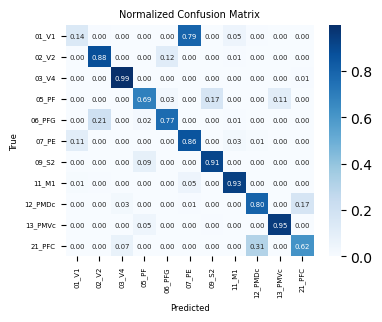

<Figure size 640x480 with 0 Axes>

In [11]:
# Normalize the confusion matrix by dividing by row sums
cm_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 5})
plt.xlabel('Predicted', fontsize=6)
plt.ylabel('True', fontsize=6)
plt.tick_params(axis='both', labelsize=5)
plt.title('Normalized Confusion Matrix', fontsize=7)
plt.savefig(os.path.join(savedir,f'hierarchical_decode_region_confusion_matrix_ncluster{n_clusters}.pdf'), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join(savedir,f'hierarchical_decode_region_confusion_matrix_ncluster{n_clusters}.png'))
plt.show()
plt.clf()